In [4]:
#plot Rossby wavenumber data for top reanalysis heatwaves
#Generate Rossby wavenumber for circumglobal waves

pathout ="/nfs/see-fs-01_teaching/ee21pnm/Project/output"

#year = "2021"
#mon= "06"
#day = 26

#lat_min = 35
#lat_max =60
#lon_min = -180 #-145
#lon_max = 180 #-100

##IMPORT PACKAGES

import cartopy.feature as cfeature ## for lakes/borders et
countries_50m = cfeature.NaturalEarthFeature('cultural','admin_0_countries','50m',edgecolor='k',facecolor='none')
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset  
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing
import xarray as xr
import datetime as dt
import seaborn as sns
sns.set_style(style='white')
from matplotlib import gridspec
import matplotlib.gridspec as gridspec

import iris
from iris.experimental.equalise_cubes import equalise_attributes
from iris.util import unify_time_units
import iris.coord_categorisation
import iris.plot as iplt
import iris.quickplot as qplt

import pandas as pd

import glob




crs = ccrs.Orthographic(115,67)

##define constants
p0 = 1000   #base pressure level
rcp = 0.286 #gas constant divided by specific heat capacity
R_gas= 8.31 #ideal gas constant
G = 9.81 #gravity

#make function to convert all floats to integers in a matrix
def f1(x):
    return np.int(x)
f2 = np.vectorize(f1)


def suffix(d):
    return 'th' if 11<=d<=13 else {1:'st',2:'nd',3:'rd'}.get(d%10, 'th')

def custom_strftime(format, t):
    return t.strftime(format).replace('{S}', str(t.day) + suffix(t.day))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


In [5]:
df2 = pd.read_excel('wavenumber.xlsx', index_col=0)

In [6]:
df2

,dates,wave-1,wave-2,wave-3,wave-4,wave-5,wave-6,wave-7,wave-8,wave-9,wave-10
0,1979-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1979-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1979-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1979-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1979-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1979-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1979-06-07,0.456648,-0.204425,1.038206,0.837584,1.619446,-1.598466,-0.860919,-0.685216,0.089009,0.424667
7,1979-06-08,0.416713,-0.631021,1.271561,0.575499,1.532449,-0.827952,-0.826413,-1.160471,-0.330291,0.444604
8,1979-06-09,0.191671,-0.593581,1.106899,0.364085,1.224032,-0.313622,-0.843584,-0.778767,-0.153015,0.722682
9,1979-06-10,-0.113082,-0.634442,0.705748,0.391429,0.841495,-0.222493,-0.955708,-0.527191,-0.739721,0.779553


In [7]:
#load MaxTemp files
#99.5th percentile and pattern corr (daily max Reanalysis 1979-2021)

#Read in spreadsheets
PNW_Corr = pd.read_excel('Spreadsheets/PNW_Corr_June2021_lowRES.xlsx', index_col=0)  
#PNW_Corr 

SIB_Corr = pd.read_excel('Spreadsheets/Siberia_Corr_June2020_lowRES.xlsx', index_col=0)  
#SIB_Corr

SIB_Corr1988 = pd.read_excel('Spreadsheets/Siberia_Corr_July1988_lowRES.xlsx', index_col=0)  
#SIB_Corr1988

PNW_MaxTemp = pd.read_excel('Spreadsheets/Maxtemp_PNW.xlsx', index_col=0)  
#PNW_MaxTemp 

SIB_MaxTemp = pd.read_excel('Spreadsheets/Maxtemp_Siberia.xlsx', index_col=0)
#SIB_MaxTemp

#join p_corr to Maxtemp dataframe
PNW_all = PNW_Corr.join(PNW_MaxTemp.set_index('dates'), on='dates')
SIB_all = SIB_Corr.join(SIB_MaxTemp.set_index('dates'), on='dates')
SIB_all_88 = SIB_Corr1988.join(SIB_MaxTemp.set_index('dates'), on='dates')

#add month column
PNW_all['Month'] = pd.to_datetime(PNW_all['dates']).dt.to_period('M')
SIB_all['Month'] = pd.to_datetime(SIB_all['dates']).dt.to_period('M')
SIB_all_88['Month'] = pd.to_datetime(SIB_all_88['dates']).dt.to_period('M')

#percentiles
pctl_SIB = np.percentile(SIB_all['Max_Temp'],99.5)
pctl_PNW = np.percentile(PNW_all['Max_Temp'],99.5)

print("pctl_PNW =", pctl_PNW)
print("pctl_SIB =", pctl_SIB)

#filter dataframe to above historical pctl
#sort values
PNW_all2 = PNW_all[PNW_all.Max_Temp > pctl_PNW]
PNW_R = PNW_all2.sort_values(by=['Max_Temp'],ascending=False)

#filter dataframe to above historical pctl
#sort values
SIB_all2 = SIB_all[SIB_all.Max_Temp > pctl_SIB]
SIB_R = SIB_all2.sort_values(by=['Max_Temp'],ascending=False)

#filter dataframe to above historical pctl
#sort values
SIB_all_882 = SIB_all_88[SIB_all_88.Max_Temp > pctl_SIB]
SIB_R_1988 = SIB_all_882.sort_values(by=['Max_Temp'],ascending=False)

#max of each month
PNWR = PNW_R.loc[PNW_R.groupby(["Month"])["Max_Temp"].idxmax()]
SIBR = SIB_R.loc[SIB_R.groupby(["Month"])["Max_Temp"].idxmax()]
SIBR1988 = SIB_R_1988.loc[SIB_R_1988.groupby(["Month"])["Max_Temp"].idxmax()]

PNWR

pctl_PNW = 29.3733229828
pctl_SIB = 29.3891264725


,dates,p_corr,SCC,RMSE,Max_Temp,Month
1215,1998-07-27,0.816340,0.205323,522.430689,30.016487,1998-07
1698,2006-07-22,0.857968,0.201373,457.490698,30.358187,2006-07
1888,2009-07-29,0.709187,0.245742,575.867371,29.802984,2009-07
2223,2015-06-28,0.823050,0.225505,596.327490,29.394321,2015-06
2589,2021-06-28,1.000000,1.000000,0.000000,34.470818,2021-06


In [8]:
#join Maxtemp dataframe to Wavenumber dataframe

PNW_joined = PNWR.join(df2.set_index('dates'), on='dates')
SIB_joined = SIBR.join(df2.set_index('dates'), on='dates')

In [9]:
PNW_joined

,dates,p_corr,SCC,RMSE,Max_Temp,Month,wave-1,wave-2,wave-3,wave-4,wave-5,wave-6,wave-7,wave-8,wave-9,wave-10
1215,1998-07-27,0.816340,0.205323,522.430689,30.016487,1998-07,0.555401,-0.576214,0.758673,0.871568,-1.304796,-0.944390,-0.526072,-0.381486,-0.436687,0.409702
1698,2006-07-22,0.857968,0.201373,457.490698,30.358187,2006-07,0.563124,-1.183925,-1.120232,0.313107,0.950748,1.141791,0.277311,0.648334,0.472290,0.026150
1888,2009-07-29,0.709187,0.245742,575.867371,29.802984,2009-07,-0.120134,1.555592,1.619973,1.115834,1.105709,0.137005,-0.498039,-0.222444,0.762474,-0.909832
2223,2015-06-28,0.823050,0.225505,596.327490,29.394321,2015-06,0.153581,-0.082908,-1.366706,2.250555,-1.564383,1.217046,0.140958,1.168594,0.102815,-1.133343
2589,2021-06-28,1.000000,1.000000,0.000000,34.470818,2021-06,-0.123319,-0.129786,-0.146021,3.759880,0.869029,1.590149,-0.873161,-0.422446,0.702854,1.165383


In [10]:
PNW_melt = pd.melt(PNW_joined[['dates', 'wave-1', 'wave-2','wave-3', 'wave-4','wave-5', 'wave-6','wave-7', 'wave-8','wave-9', 'wave-10']],id_vars='dates',var_name='Wavenumber', value_name='Amplitude')
PNW_melt['dates2']= PNW_melt['dates'].dt.strftime('%Y-%m-%d')
#PNW_melt = pd.melt(PNW_joined, id_vars='dates')

In [11]:
SIB_melt = pd.melt(SIB_joined[['dates', 'wave-1', 'wave-2','wave-3', 'wave-4','wave-5', 'wave-6','wave-7', 'wave-8','wave-9', 'wave-10']],id_vars='dates',var_name='Wavenumber', value_name='Amplitude')
SIB_melt['dates2']= SIB_melt['dates'].dt.strftime('%Y-%m-%d')
#SIB_melt = pd.melt(SIB_joined, id_vars='dates')

SIB_melt

,dates,Wavenumber,Amplitude,dates2
0,1988-07-25,wave-1,1.787657,1988-07-25
1,1991-07-07,wave-1,-1.670843,1991-07-07
2,2001-07-27,wave-1,1.220556,2001-07-27
3,2010-07-05,wave-1,0.132804,2010-07-05
4,2014-07-17,wave-1,-0.319411,2014-07-17
5,2018-07-08,wave-1,0.325221,2018-07-08
6,2020-06-20,wave-1,-1.597197,2020-06-20
7,2021-07-03,wave-1,-2.210240,2021-07-03
8,1988-07-25,wave-2,-1.627626,1988-07-25
9,1991-07-07,wave-2,0.757454,1991-07-07


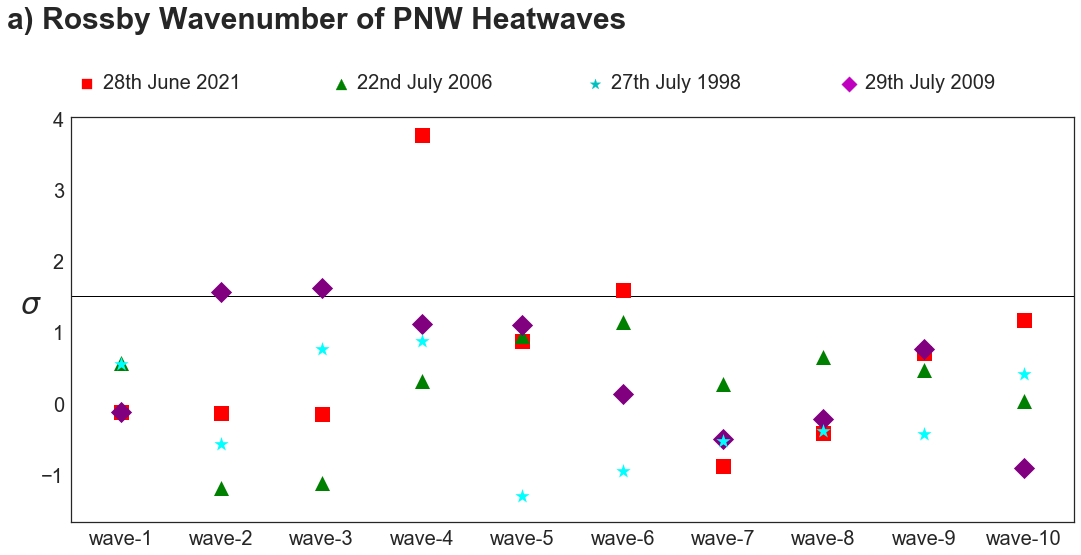

In [31]:
#plot


c='white'

#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

fig1 = plt.figure(figsize=(15,7))
#gs = gridspec.GridSpec(1,20)

#ax3 = fig1.add_subplot(1,1,1)

gs = gridspec.GridSpec(20,4)
ax3 = fig1.add_subplot(gs[2:20,0:4])

#ax3.yaxis.set_visible(False)
#ax5.yaxis.set_viSIB88le(False)


#sns.boxplot(x="variable", y="value", data=pd.melt(PNW245_all),ax=ax3,linewidth=0,  palette="Reds")


sns.stripplot(y=PNW_melt[PNW_melt['dates']=='2021-06-28']["Amplitude"],x=PNW_melt[PNW_melt['dates']=='2021-06-28']["Wavenumber"], marker = 's', color='red',ax=ax3, linewidth=0, size=15)
sns.stripplot(y=PNW_melt[PNW_melt['dates']=='2006-07-22']["Amplitude"],x=PNW_melt[PNW_melt['dates']=='2006-07-22']["Wavenumber"], marker = '^', color='green',ax=ax3, linewidth=0, size=15)
sns.stripplot(y=PNW_melt[PNW_melt['dates']=='2009-07-29']["Amplitude"],x=PNW_melt[PNW_melt['dates']=='2009-07-29']["Wavenumber"], marker = 'D', color='purple',ax=ax3, linewidth=0, size=15)
sns.stripplot(y=PNW_melt[PNW_melt['dates']=='1998-07-27']["Amplitude"],x=PNW_melt[PNW_melt['dates']=='1998-07-27']["Wavenumber"], marker = '*', color='cyan',ax=ax3, linewidth=0, size=15)
#sns.stripplot(y=PNW_melt[PNW_melt['dates']=='2015-06-28']["Amplitude"],x=PNW_melt[PNW_melt['dates']=='2015-06-28']["Wavenumber"], marker = '.', color='black',ax=ax3, linewidth=0, size=15)
#sns.swarmplot(x="variable", y="value", data=pd.melt(df),ax=ax3,linewidth=0,  split=True, size=5, palette="Reds")
#ax3.set(ylim=(0,1))
#ax3.set(ylabel=r'$\sigma$', labelsize=30)
ax3.set(xlabel='')
ax3.axhline(y=1.5, color='k', linewidth = 1)
#plt.legend(title='', loc='best')
#, bbox_to_anchor=(0.14, 1.22)
#plt.setp(ax3.get_legend().get_title(), fontsize='10')
#plt.setp(ax3.get_legend().get_texts(), fontsize='10')
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax3.set_ylabel(r'$\sigma$', fontsize=30, rotation=0, labelpad= 10)
#ax3.set_title('2015-2100', size=15, fontweight = 'light')
ax3.grid(False)

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, loc='upper center')
#n.legend(handles[:4], labels[:4])

#add custom legend
date_string_list = ['2021-06-28', '2006-07-22', '1998-07-27', '2009-07-29']
color_list = ['r','g','c','m', 'k']
marker_list = ['s','^','*','D', '.']
count = 0
column_number = 0
for date_string in date_string_list:
    date_text = custom_strftime('{S} %B %Y', dt.datetime.strptime(date_string, '%Y-%m-%d'))
    #year = date_string[0:4]
    #mon = date_string[5:7]
    #mainday = int(date_string[8:10])
    ax2 = fig1.add_subplot(gs[0:2,column_number])
    ax2.set(xlim=(0, 15), ylim=(0, 3))
    ax2.scatter(1,1.5, color=color_list[column_number], marker =marker_list[column_number], s=120)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.annotate(date_text,xy=(1,1.5), fontsize=20, fontweight='light',xytext=(2,1))
    column_number = column_number + 1
        

#plt.suptitle('PNW Reanalysis Wavenumber', y=1.1,x=0.02,fontsize=30,horizontalalignment='left',fontweight = 'bold')
plt.suptitle('a) Rossby Wavenumber of PNW Heatwaves',fontsize=30,y=1.1,x=0,horizontalalignment='left',weight = 'bold')
plt.tight_layout()
plt.savefig('PNW Reanalysis Wavenumber.png',format ='png', dpi=150, bbox_inches='tight')
plt.show()

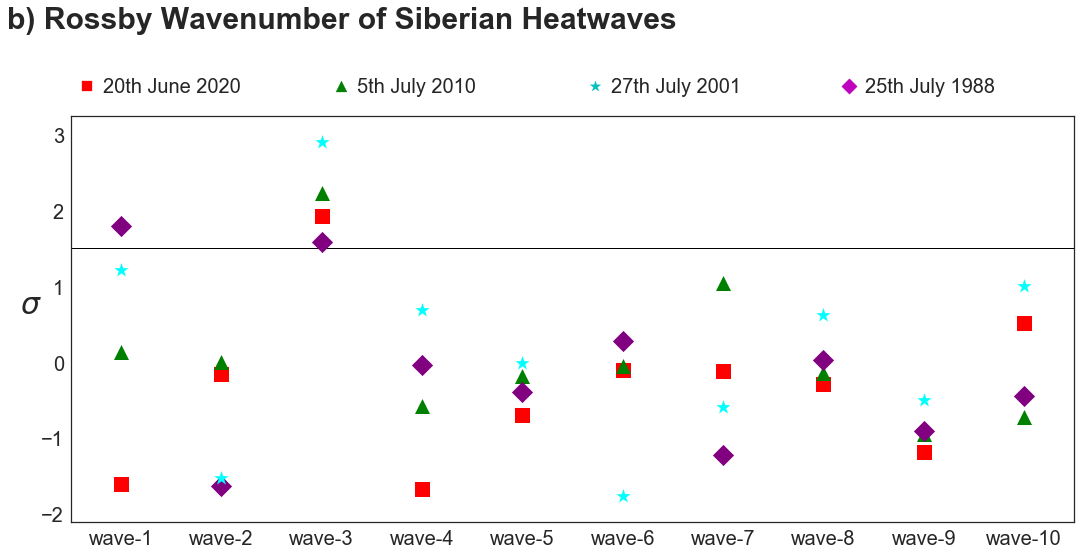

In [32]:
#plot SIberia


c='white'

#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

fig1 = plt.figure(figsize=(15,7))
#gs = gridspec.GridSpec(1,20)

#ax3 = fig1.add_subplot(1,1,1)

gs = gridspec.GridSpec(20,4)
ax3 = fig1.add_subplot(gs[2:20,0:4])

#ax3.yaxis.set_visible(False)
#ax5.yaxis.set_viSIB88le(False)


#sns.boxplot(x="variable", y="value", data=pd.melt(PNW245_all),ax=ax3,linewidth=0,  palette="Reds")


sns.stripplot(y=SIB_melt[SIB_melt['dates']=='2020-06-20']["Amplitude"],x=SIB_melt[SIB_melt['dates']=='2020-06-20']["Wavenumber"], marker = 's', color='red',ax=ax3, linewidth=0, size=15)
sns.stripplot(y=SIB_melt[SIB_melt['dates']=='2010-07-05']["Amplitude"],x=SIB_melt[SIB_melt['dates']=='2010-07-05']["Wavenumber"], marker = '^', color='green',ax=ax3, linewidth=0, size=15)
sns.stripplot(y=SIB_melt[SIB_melt['dates']=='1988-07-25']["Amplitude"],x=SIB_melt[SIB_melt['dates']=='1988-07-25']["Wavenumber"], marker = 'D', color='purple',ax=ax3, linewidth=0, size=15)
sns.stripplot(y=SIB_melt[SIB_melt['dates']=='2001-07-27']["Amplitude"],x=SIB_melt[SIB_melt['dates']=='2001-07-27']["Wavenumber"], marker = '*', color='cyan',ax=ax3, linewidth=0, size=15)
#sns.stripplot(y=SIB_melt[SIB_melt['dates']=='2015-06-28']["Amplitude"],x=SIB_melt[SIB_melt['dates']=='2015-06-28']["Wavenumber"], marker = '.', color='black',ax=ax3, linewidth=0, size=15)
#sns.swarmplot(x="variable", y="value", data=pd.melt(df),ax=ax3,linewidth=0,  split=True, size=5, palette="Reds")
#ax3.set(ylim=(0,1))
#ax3.set(ylabel=r'$\sigma$', labelsize=30)
ax3.set(xlabel='')
ax3.axhline(y=1.5, color='k', linewidth = 1)
#plt.legend(title='', loc='best')
#, bbox_to_anchor=(0.14, 1.22)
#plt.setp(ax3.get_legend().get_title(), fontsize='10')
#plt.setp(ax3.get_legend().get_texts(), fontsize='10')
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax3.set_ylabel(r'$\sigma$', fontsize=30, rotation=0, labelpad= 10)
#ax3.set_title('2015-2100', size=15, fontweight = 'light')
ax3.grid(False)

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, loc='upper center')
#n.legend(handles[:4], labels[:4])

#add custom legend
date_string_list = ['2020-06-20', '2010-07-05', '2001-07-27', '1988-07-25']
color_list = ['r','g','c','m']
marker_list = ['s','^','*','D']
count = 0
column_number = 0
for date_string in date_string_list:
    date_text = custom_strftime('{S} %B %Y', dt.datetime.strptime(date_string, '%Y-%m-%d'))
    #year = date_string[0:4]
    #mon = date_string[5:7]
    #mainday = int(date_string[8:10])
    ax2 = fig1.add_subplot(gs[0:2,column_number])
    ax2.set(xlim=(0, 15), ylim=(0, 3))
    ax2.scatter(1,1.5, color=color_list[column_number], marker =marker_list[column_number], s=120)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.annotate(date_text,xy=(1,1.5), fontsize=20,fontweight='light',xytext=(2,1))
    column_number = column_number + 1
        

plt.suptitle('b) Rossby Wavenumber of Siberian Heatwaves',fontsize=30,y=1.1,x=0,horizontalalignment='left',weight = 'bold')
plt.tight_layout()
plt.savefig('Siberia Reanalysis Wavenumber.png',format ='png', dpi=150, bbox_inches='tight')
plt.show()